# 2010 RF12 (visualisations et simulations numériques en Python)

## Description

### Introduction

L'astéroïde "2010 RF12" est un "tout petit astéroïde" (1), avec une dimension estimée de 7 mètres, et une masse estimée de 500 tonnes. La probabilité d'impact avec la Terre est estimée à 10% en 2095 (1).

(1) https://en.wikipedia.org/wiki/2010_RF12

L'estimation de sa trajectoire donne accès à plusieurs dates auxquelles il sera au plus proche de la Terre. La rubrique "Close Approach Data" sur le site "Small-Body Database Lookup" (2) du JPL permet d'obtenir ces informations.

(2) https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=2010%20RF12&view=OPC

Sur ce site, on obtient la table ci-dessous, avec une "distance nominale" classée par ordre croissant.
```
Date/Time (TDB)                 Body           Nominal Distance (km)    Minimum Distance (km)      Maximum Distance (km)
2095-Sep-06 00:06 ±   00:20     Earth          51907                    1554                       236516
2010-Sep-08 21:13 ± < 00:01     Earth          79381                    79380                      79381
2010-Sep-09 13:56 ± < 00:01     Moon           108190                   108189                     108191
1915-Sep-11 04:41 ±   00:25     Moon           354853                   327993                     381715
2095-Sep-06 08:42 ±   16:44     Moon           405909                   25069                      803787
1915-Sep-10 06:13 ±   00:08     Earth          463223                   435921                     490650
2059-Feb-17 12:08 ±   00:07     Earth          3534843                  3528821                    3540865
1998-Apr-01 01:04 ±   00:01     Earth          4050362                  4050333                    4050390
2009-Sep-09 08:42 ± < 00:01     Earth          4083600                  4082398                    4084803
1916-Sep-08 04:52 ±   00:48     Earth          5042106                  4905899                    5178312
```
La visualisation des trajectoires sur différentes périodes de temps, et leur simulation, montrent la difficulté de prédire ces trajectoires à long terme et le changement notable de trajectoire après chaque passage à proximité de la Terre.

### Etapes suivies

On génère le fichier avec la liste des astres qui nous concerneront.
```python
planetes(Planetes='Planetes.csv',Ligne = '2010RF12,0,km^3 s^-2,2010 RF12')
```

Ce fichier a le contenu visualisé ci-dessous.
```python
         Nom            mu      units         id
0     Soleil  1.327124e+11  km^3 s^-2         10
1    Mercure  2.203187e+04  km^3 s^-2          1
2      Venus  3.248586e+05  km^3 s^-2          2
3      Terre  3.986004e+05  km^3 s^-2        399
4       Lune  4.902800e+03  km^3 s^-2        301
5       Mars  4.282838e+04  km^3 s^-2          4
6    Jupiter  1.267128e+08  km^3 s^-2          5
7    Saturne  3.794058e+07  km^3 s^-2          6
8     Uranus  5.794556e+06  km^3 s^-2          7
9    Neptune  6.836527e+06  km^3 s^-2          8
10  2010RF12  0.000000e+00  km^3 s^-2  2010 RF12
```

Les éphémérides des astres présents dans la liste sont sauvegardées dans des fichiers CSV.
```python
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='1900-01-01 00:00:00',fin='2100-01-01 00:00:00',pas='1 days')
```

On peut alors visualiser la distance à laquelle l'astéroïde se trouve par rapport à un astre de référence, comme la Terre.
```python
trace2D(Astre1='Terre', Astre2='2010RF12')
```

La trajectoire de cet astéroïde peut aussi être visualisée.
```python
trace3D(Astre1='Soleil', Astre2='2010RF12')
```


## Code initial à exécuter avant d'utiliser les fonctions (fichier **asteroide.py**)

In [ ]:
# -*- coding: utf-8 -*-
"""
asteroide
@author: KM (27/09/2024)
"""
# importation des packages
import numpy as np
from numpy.linalg import norm
from datetime import datetime
from scipy.interpolate import CubicSpline
import pandas as pd
import requests as rq
import io
import matplotlib.pyplot as plt

# Génération du fichier planetes.csv


def planetes(Planetes='Planetes.csv', Ligne='2024PT5,0,km^3 s^-2,2024 PT5'):
    chaine = """
Nom,mu,units,id
Soleil,132712440041.279419,km^3 s^-2,10
Mercure,22031.868551,km^3 s^-2,1
Venus,324858.592000,km^3 s^-2,2
Terre,398600.435507,km^3 s^-2,399
Lune,4902.800118,km^3 s^-2,301
Mars,42828.375816,km^3 s^-2,4
Jupiter,126712764.100000,km^3 s^-2,5
Saturne,37940584.841800,km^3 s^-2,6
Uranus,5794556.400000,km^3 s^-2,7
Neptune,6836527.100580,km^3 s^-2,8
""" + Ligne
    f = io.StringIO(chaine)
    df_planetes = pd.read_csv(f)
    f.close()
    print(df_planetes)
    df_planetes.to_csv(Planetes, index=False)

# Lecture des fichiers CSV (liste des planètes ou éphémérides des planètes)


def lire_info_csv(nom):
    df = pd.read_csv(nom)
    return df

# requête avec l'API du JPL
# id : identifiant de l'astre
# debut,fin,pas : intervalle de temps sélectionné, et le pas temporel
# les positions et les vitesses sont données dans le référentiel ICRS
# (@SSB : Solar System Barycenter)


def req_jpl_read(id, debut='2023-01-01 00:00:00', fin='2043-01-01 00:00:00', pas='8 h'):
    # envoi de la requête (CENTER='@SSB' : Solar System Barycenter)
    rep = rq.get('https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=\''+str(id) +
                 '\'&OBJ_DATA=\'YES\'&MAKE_EPHEM=\'YES\'&EPHEM_TYPE=\'VECTORS\'&VEC_TABLE=\'2\'&CSV_FORMAT=\'YES\'&CENTER=\'@SSB\'&START_TIME=\''+debut+'\'&STOP_TIME=\''+fin+'\'&STEP_SIZE=\''+pas+'\'')
    # récupération et traitement du contenu en retour de la requête
    f = io.StringIO(rep.content.decode())
    lines = f.readlines()
    for line in lines:
        if line.find('$$SOE') != -1:
            debut = lines.index(line)
        if line.find('$$EOE') != -1:
            nlignes = lines.index(line)-debut-1
    f.close()
    # liste des lignes à ne pas prendre en compte
    skip = [n for n in range(0, debut-2)]
    skip.append(debut-1), skip.append(debut)
    # lecture du fichier de données
    f = io.StringIO(rep.content.decode())
    df = pd.read_csv(f, skiprows=skip, nrows=nlignes)
    f.close()
    # élimination de la dernière colonne qui est vide
    df = df.drop(df.columns[-1], axis=1)
    # format datetime pour les dates (en colonne 1)
    dates = pd.to_datetime(df.iloc[:, 1], format=' A.D. %Y-%b-%d %H:%M:%S.%f')
    df = df.drop(df.columns[1], axis=1)
    df.insert(1, 'DATES', dates)
    # noms des colonnes sans espace
    noms_col = [df.columns.values[n].strip()
                for n in range(len(df.columns.values))]
    df.columns = noms_col
    return df

# Les données initialement téléchargées à partir du site "JPL Horizons"
# sont reproduites dans un format plus pratique, pour d'autres utilisations


def convert_req_jpl_to_csv(Planetes='Planetes.csv', debut='2023-01-01 00:00:00', fin='2043-01-01 00:00:00', pas='8 h'):
    # Lecture des informations sur les astres
    df_planetes = pd.read_csv(Planetes)
    # Nombre d'astres considérés pour la conversion de fichier
    N = len(df_planetes)
    # sauvegarde au format csv
    for n in range(N):
        print('Données pour '+df_planetes.loc[n, 'Nom'])
        df = req_jpl_read(df_planetes.loc[n, 'id'], debut, fin, pas)
        df.to_csv(df_planetes.loc[n, 'Nom']+'.csv', index=False)


# Affichage des données du fichier contenant les éphémérides de l'astre désigné


def jpl_affiche(Astre):
    df = pd.read_csv(Astre+'.csv')
    print('**********')
    # noms des colonnes
    print('>>>noms des colonnes :'), print(df.columns.values)
    # type de chaque colonne
    print('\n>>>types des colonnes :'), print(df.dtypes)
    # contenu du dataframe
    print('\n>>>aperçu du contenu :'), print(df)
    print('**********')


# Méthode générique de résolution numérique d'équation différentielle ordinaire
# y'=f(t,y)
# (Runge-Kutta d'ordre 4)
# la fonction f est de la forme f(t,y)
# t est une liste d'instants sur lesquels s'effectue la résolution
# y0 est la condition initiale


def rk4(f, t, y0):
    y = np.zeros((len(t), len(y0)))
    k1 = np.zeros(len(y0))
    k2 = np.copy(k1)
    k3 = np.copy(k1)
    k4 = np.copy(k1)
    y[0, :] = y0[:]
    for n in np.arange(1, len(t)):
        yprec = y[n-1]
        tprec = t[n-1]
        h = t[n]-tprec
        k1[:] = f(tprec, yprec)
        k2[:] = f(tprec+h/2, yprec+(h/2)*k1)
        k3[:] = f(tprec+h/2, yprec+(h/2)*k2)
        k4[:] = f(tprec+h, yprec+h*k3)
        y[n, :] = yprec+(h/6)*(k1+2*k2+2*k3+k4)
    return t, y

# Méthode rk8
# (Runge-Kutta d'ordre 8)


def rk8(f, t, y0):
    y = np.zeros((len(t), len(y0)))
    k1 = np.zeros(len(y0))
    k2 = np.copy(k1)
    k3 = np.copy(k1)
    k4 = np.copy(k1)
    k5 = np.copy(k1)
    k6 = np.zeros(len(y0))
    k7 = np.copy(k1)
    k8 = np.copy(k1)
    k9 = np.copy(k1)
    k10 = np.copy(k1)
    y[0, :] = y0[:]
    for n in np.arange(1, len(t)):
        yprec = y[n-1]
        tprec = t[n-1]
        h = t[n]-tprec
        k1[:] = f(tprec, yprec)
        k2[:] = f(tprec+h*(4/27), yprec+(h*4/27)*k1)
        k3[:] = f(tprec+h*(2/9), yprec+(h/18)*(k1+3*k2))
        k4[:] = f(tprec+h*(1/3), yprec+(h/12)*(k1+3*k3))
        k5[:] = f(tprec+h*(1/2), yprec+(h/8)*(k1+3*k4))
        k6[:] = f(tprec+h*(2/3), yprec+(h/54)*(13*k1-27*k3+42*k4+8*k5))
        k7[:] = f(tprec+h*(1/6), yprec+(h/4320) *
                  (389*k1-54*k3+966*k4-824*k5+243*k6))
        k8[:] = f(tprec+h, yprec+(h/20) *
                  (-231*k1+81*k3-1164*k4+656*k5-122*k6+800*k7))
        k9[:] = f(tprec+h*(5/6), yprec+(h/288) *
                  (-127*k1+18*k3-678*k4+456*k5-9*k6+576*k7+4*k8))
        k10[:] = f(tprec+h, yprec+(h/820)*(1481*k1-81*k3 +
                   7104*k4-3376*k5+72*k6-5040*k7-60*k8+720*k9))
        y[n, :] = yprec+(h/840)*(41*k1+27*k4+272*k5+27*k6+216*k7+216*k9+41*k10)
    return t, y

# équation dynamique pour l'astéroïde


def equ_dyn_aster(t, y, mu, positions):
    N = len(mu)-1
    yp = np.zeros(6)
    yp[0:3] = y[3:6]
    P = y[0:3]
    for n in range(N):
        Pn = positions[n](t)
        yp[3:6] = yp[3:6]-mu[n] * \
            (P-Pn)/np.sqrt(sum((P-Pn)**2))**3
    return yp


# tracé en 3D d'une trajectoire relative (échelles en millions de km)


def trace3D_traj(Astre1, Astre2, XYZ, elev=30, azim=-60, roll=0):
    XYZ = XYZ/1e6
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')
    ax.plot3D(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], 'b', label=Astre2, lw=0.5)
    ax.scatter(0, 0, 0, c='r', label=Astre1)
    ax.scatter(XYZ[0, 0], XYZ[0, 1], XYZ[0, 2], c='b', label='début')
    ax.scatter(XYZ[-1, 0], XYZ[-1, 1], XYZ[-1, 2], c='g', label='fin')
    ax.set_title('Trajectoire '+Astre2+' (origine '+Astre1+')')
    ax.set_xlabel('X (en millions de km)'), ax.set_ylabel(
        'Y (en millions de km)'), ax.set_zlabel('Z (en millions de km)')
    ax.axis('equal')
    ax.view_init(elev, azim, roll)
    ax.legend()

# tracé en 3D de l'erreur sur la trajectoire (JPL vs. simulation)


def trace3D_err(Astre1, Astre2, XYZ_err, elev=30, azim=-60, roll=0):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')
    ax.plot3D(XYZ_err[:, 0], XYZ_err[:, 1], XYZ_err[:, 2], 'b', lw=0.5)
    ax.scatter(XYZ_err[0, 0], XYZ_err[0, 1],
               XYZ_err[0, 2], c='b', label='début')
    ax.scatter(XYZ_err[-1, 0], XYZ_err[-1, 1],
               XYZ_err[-1, 2], c='g', label='fin')
    ax.set_title('Erreur sur la trajectoire '+Astre2+' (origine '+Astre1+')')
    ax.set_xlabel('X (en km)'), ax.set_ylabel(
        'Y (en km)'), ax.set_zlabel('Z (en km)')
    ax.axis('equal')
    ax.view_init(elev, azim, roll)
    ax.legend()

# tracé en 2D de l'erreur sur la distance (JPL vs. simulation)


def trace2D_err(Astre1, Astre2, XYZ_err, dates):
    plt.figure(figsize=(10, 8))
    plt.plot(dates, np.sqrt(XYZ_err[:, 0]**2 +
             XYZ_err[:, 1]**2+XYZ_err[:, 2]**2), 'b', lw=0.5)
    plt.title('Erreur sur la distance '+Astre2+' (origine '+Astre1+')')
    plt.xlabel('temps (dates)'), plt.ylabel('distance (en km)')
    plt.grid('on')

# tracé en 2D de la distance


def trace2D_dist(Astre1, Astre2, XYZ_dist, dates):
    plt.figure(figsize=(10, 8))
    plt.plot(dates, np.sqrt(XYZ_dist[:, 0]**2 +
             XYZ_dist[:, 1]**2+XYZ_dist[:, 2]**2)/1e6, 'b', lw=0.5)
    plt.title('Distance '+Astre2+' (origine '+Astre1+')')
    plt.xlabel('temps (dates)'), plt.ylabel('distance (en millions de km)')
    plt.grid('on')

# tracé en 3D de la trajectoire selon les astres choisis


def trace3D(Astre1='Terre', Astre2='Lune', elev=30, azim=-60, roll=0):
    # Lecture des éphémérides complètes pour les tracés
    df_Astre1 = pd.read_csv(Astre1+'.csv')
    df_Astre2 = pd.read_csv(Astre2+'.csv')
    # Récupération des éphémérides pour les deux astres choisis
    P1_jpl = df_Astre1.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P2_jpl = df_Astre2.loc[:, ['X', 'Y', 'Z']].to_numpy()
    XYZ_jpl = P2_jpl-P1_jpl
    # Tracé des résultats
    trace3D_traj(Astre1, Astre2, XYZ_jpl, elev, azim, roll)
    plt.show()

# tracé en 2D de la distance entre les astres choisis


def trace2D(Astre1='Terre', Astre2='Lune'):
    # Lecture des éphémérides complètes pour les tracés
    df_Astre1 = pd.read_csv(Astre1+'.csv')
    df_Astre2 = pd.read_csv(Astre2+'.csv')
    # Récupération des éphémérides pour les deux astres choisis
    P1_jpl = df_Astre1.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P2_jpl = df_Astre2.loc[:, ['X', 'Y', 'Z']].to_numpy()
    XYZ_jpl = (P2_jpl-P1_jpl)
    # Tracé des résultats
    trace2D_dist(Astre1, Astre2, XYZ_jpl,
                 pd.to_datetime(df_Astre1.loc[:, 'DATES']))
    plt.show()

# comparaison de trajectoires (a : référence, b : calcul)


def compare(Astre1_a='Terre', Astre2_a='Lune', Astre1_b='Terre_simu', Astre2_b='Lune_simu', elev=30, azim=-60, roll=0):
    # Lecture des éphémérides complètes pour les tracés
    df_Astre1_a = pd.read_csv(Astre1_a+'.csv')
    df_Astre2_a = pd.read_csv(Astre2_a+'.csv')
    df_Astre1_b = pd.read_csv(Astre1_b+'.csv')
    df_Astre2_b = pd.read_csv(Astre2_b+'.csv')
    # Récupération des éphémérides pour les deux astres choisis
    P1_a = df_Astre1_a.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P2_a = df_Astre2_a.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P1_b = df_Astre1_b.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P2_b = df_Astre2_b.loc[:, ['X', 'Y', 'Z']].to_numpy()
    # calcul de la position relative
    XYZ_a = P2_a-P1_a
    XYZ_b = P2_b-P1_b
    # Erreur entre valeurs des éphémérides
    XYZ_err = XYZ_b-XYZ_a
    # Tracé des résultats
    trace3D_traj(Astre1_b, Astre2_b, XYZ_b, elev, azim, roll)
    trace3D_err(Astre1_b, Astre2_b, XYZ_err, elev, azim, roll)
    trace2D_err(Astre1_b, Astre2_b, XYZ_err,
                pd.to_datetime(df_Astre1_b.loc[:, 'DATES']))
    trace2D_dist(Astre1_b, Astre2_b, XYZ_b,
                 pd.to_datetime(df_Astre1_b.loc[:, 'DATES']))
    plt.show()

# simulation numérique de la trajectoire de l'asteroïde


def simu_aster_save(Planetes='Planetes.csv', methode='rk8'):
    # choix de la méthode d'intégration numérique
    if methode == 'rk4':
        meth = rk4
    if methode == 'rk8':
        meth = rk8
    # Lecture des informations sur les astres
    df_planetes = lire_info_csv(Planetes)
    # Nombre d'astres considérés pour la simulation
    N = len(df_planetes)
    # Liste des paramètres gravitationnels standards
    mu = []
    for n in range(N):
        print(df_planetes.loc[n, 'Nom']+' : ' +
              str(df_planetes.loc[n, 'mu'])+' '+df_planetes.loc[n, 'units'])
        mu.append(df_planetes.loc[n, 'mu'])
    # Lectures des valeurs initiales dans les fichiers d'éphémérides
    vi = pd.read_csv(df_planetes.loc[N-1, 'Nom']+'.csv', nrows=1)
    # Constitution de la condition initiale
    y0 = []
    y0 = np.concatenate((y0, vi.loc[0, ['X', 'Y', 'Z']].values))
    y0 = np.concatenate((y0, vi.loc[0, ['VX', 'VY', 'VZ']].values))
    y0 = y0.flatten()
    df_temps = pd.read_csv('Soleil.csv')
    t_jpl = 3600*24*(df_temps.loc[:, 'JDTDB']-df_temps.loc[0, 'JDTDB']).values
    positions = []
    for n in range(N-1):
        df_Astre = pd.read_csv(df_planetes.loc[n, 'Nom']+'.csv')
        XYZ = df_Astre.loc[:, ['X', 'Y', 'Z']].values
        positions.append(CubicSpline(t_jpl, XYZ))
    # Lancement de la simulation numérique
    print('début de la simulation numérique')
    start = datetime.now()
    _, y = meth(lambda t, y: equ_dyn_aster(t, y, mu, positions), t_jpl, y0)
    end = datetime.now()
    print(f'fin de la simulation à {end - start} (hh:mm:ss.ms)')
    df_Astre = pd.read_csv(df_planetes.loc[N-1, 'Nom']+'.csv')
    df_Astre_simu = df_Astre.copy()
    df_Astre_simu = df_Astre_simu.drop(df_Astre_simu.columns[2:], axis=1)
    df_Astre_simu.insert(2, 'X', y[:, 0])
    df_Astre_simu.insert(3, 'Y', y[:, 1])
    df_Astre_simu.insert(4, 'Z', y[:, 2])
    df_Astre_simu.insert(5, 'VX', y[:, 3])
    df_Astre_simu.insert(6, 'VY', y[:, 4])
    df_Astre_simu.insert(7, 'VZ', y[:, 5])
    df_Astre_simu.to_csv(
        df_planetes.loc[N-1, 'Nom']+'_simu.csv', index=False)


## 2010 RF12

### Trajectoire entre 1900 et 2100

In [ ]:
planetes(Planetes='Planetes.csv',Ligne = '2010RF12,0,km^3 s^-2,2010 RF12')

         Nom            mu      units         id
0     Soleil  1.327124e+11  km^3 s^-2         10
1    Mercure  2.203187e+04  km^3 s^-2          1
2      Venus  3.248586e+05  km^3 s^-2          2
3      Terre  3.986004e+05  km^3 s^-2        399
4       Lune  4.902800e+03  km^3 s^-2        301
5       Mars  4.282838e+04  km^3 s^-2          4
6    Jupiter  1.267128e+08  km^3 s^-2          5
7    Saturne  3.794058e+07  km^3 s^-2          6
8     Uranus  5.794556e+06  km^3 s^-2          7
9    Neptune  6.836527e+06  km^3 s^-2          8
10  2010RF12  0.000000e+00  km^3 s^-2  2010 RF12


In [ ]:
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='1900-01-01 00:00:00',fin='2100-01-01 00:00:00',pas='1 days')

Données pour Soleil
Données pour Mercure
Données pour Venus
Données pour Terre
Données pour Lune
Données pour Mars
Données pour Jupiter
Données pour Saturne
Données pour Uranus
Données pour Neptune
Données pour 2010RF12


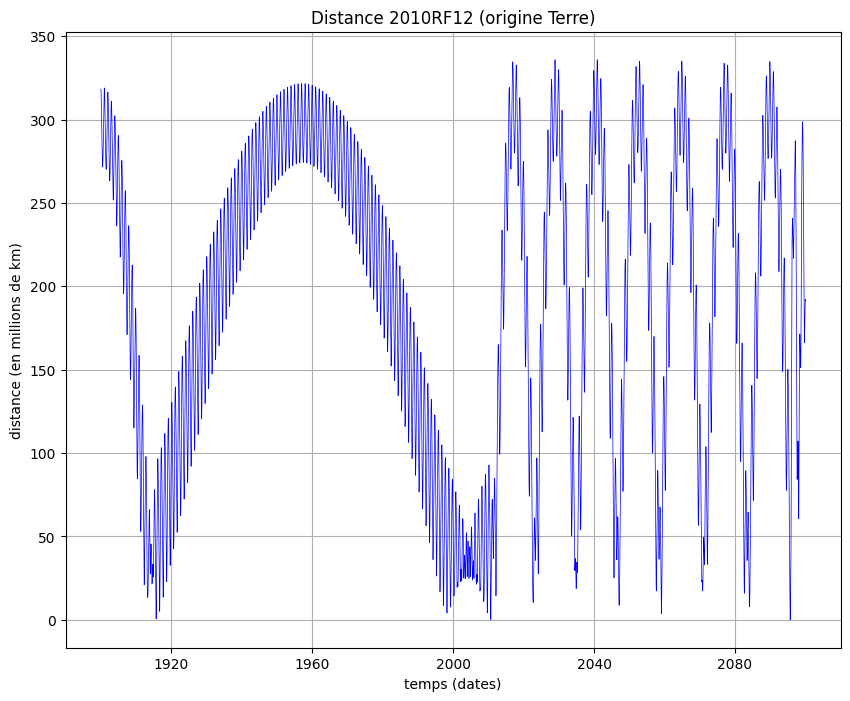

In [ ]:
trace2D(Astre1='Terre', Astre2='2010RF12')

On retrouve les différents instants où l'astéroïde est proche de la Terre.

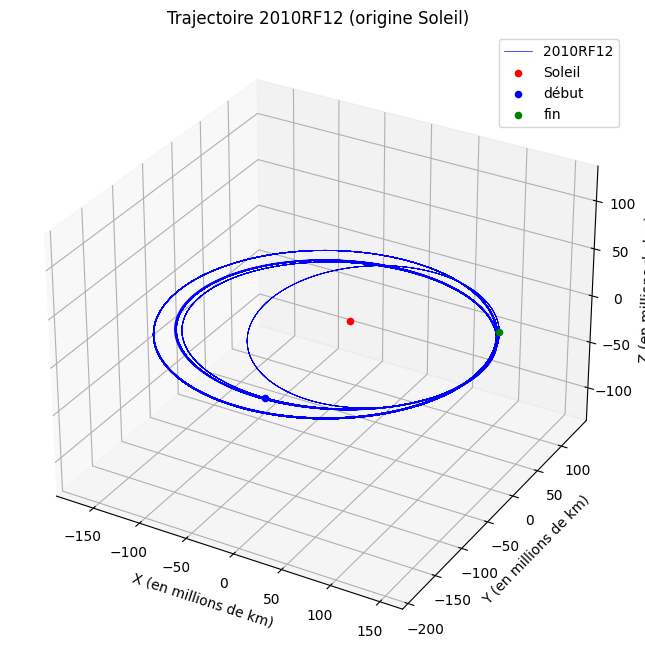

In [ ]:
trace3D(Astre1='Soleil', Astre2='2010RF12')

Après chaque passage à proximité de la Terre, l'astéroïde change assez radicalement d'orbite.

### Trajectoire et simulation entre 2094 et 2097

In [ ]:
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2094-01-01 00:00:00',fin='2097-01-01 00:00:00',pas='8 h')

Données pour Soleil
Données pour Mercure
Données pour Venus
Données pour Terre
Données pour Lune
Données pour Mars
Données pour Jupiter
Données pour Saturne
Données pour Uranus
Données pour Neptune
Données pour 2010RF12


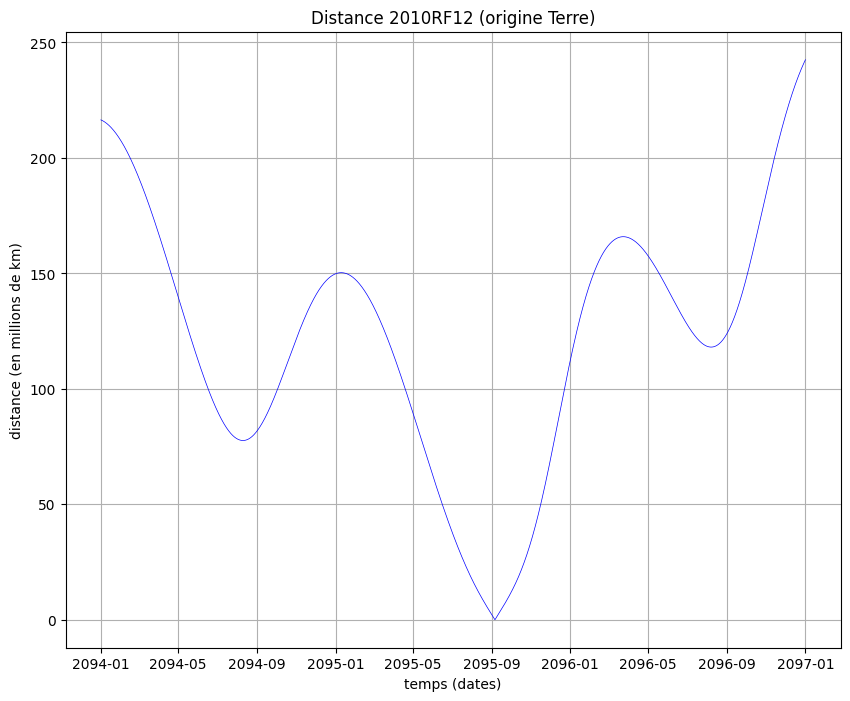

In [ ]:
trace2D(Astre1='Terre', Astre2='2010RF12')

On localise plus précisément l'instant où l'astéroïde sera au plus proche de la Terre.

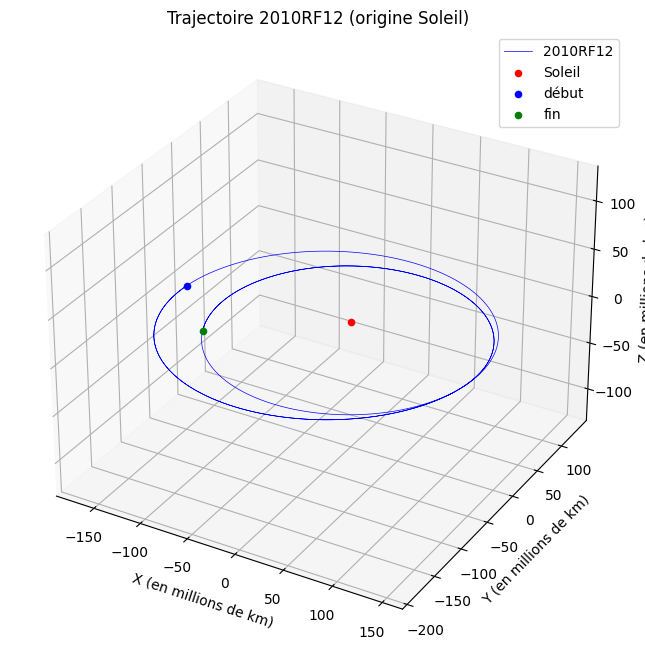

In [ ]:
trace3D(Astre1='Soleil', Astre2='2010RF12')

Le changement d'orbite après le passage à proximité de la Terre sera assez radical.

In [ ]:
simu_aster_save(Planetes='Planetes.csv',methode='rk8')

Soleil : 132712440041.2794 km^3 s^-2
Mercure : 22031.868551 km^3 s^-2
Venus : 324858.592 km^3 s^-2
Terre : 398600.435507 km^3 s^-2
Lune : 4902.800118 km^3 s^-2
Mars : 42828.375816 km^3 s^-2
Jupiter : 126712764.1 km^3 s^-2
Saturne : 37940584.8418 km^3 s^-2
Uranus : 5794556.4 km^3 s^-2
Neptune : 6836527.10058 km^3 s^-2
2010RF12 : 0.0 km^3 s^-2
début de la simulation numérique
fin de la simulation à 0:00:08.970518 (hh:mm:ss.ms)


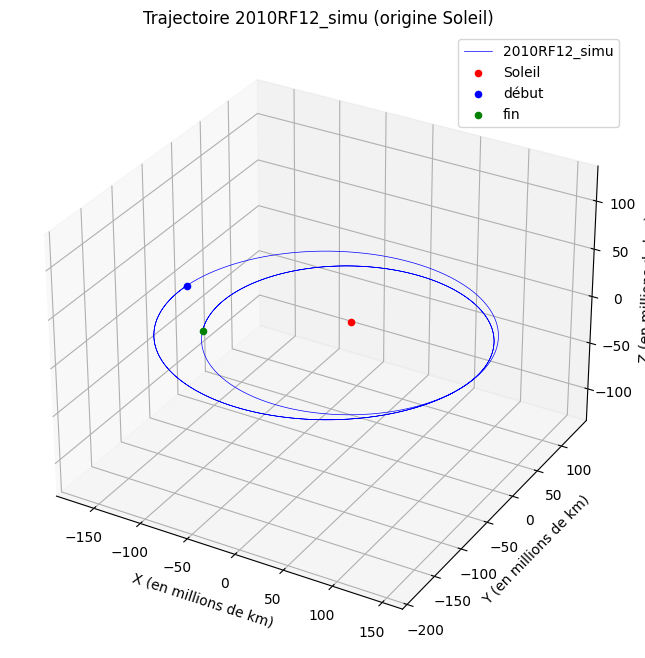

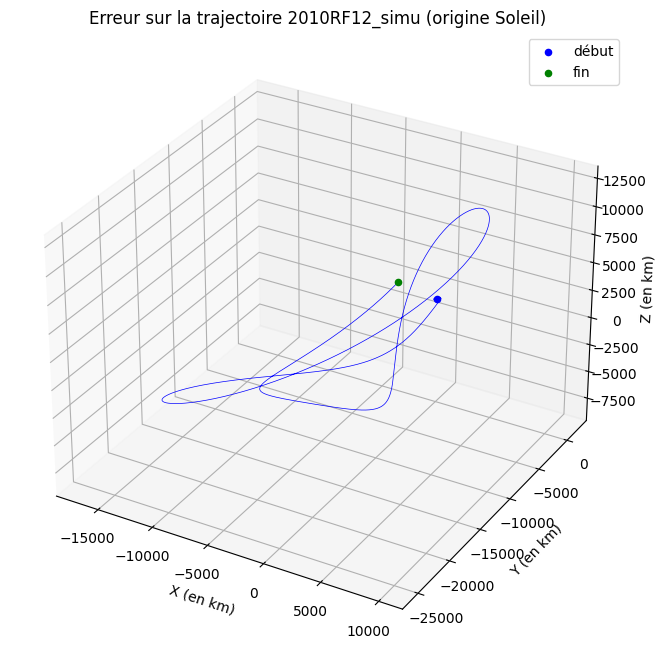

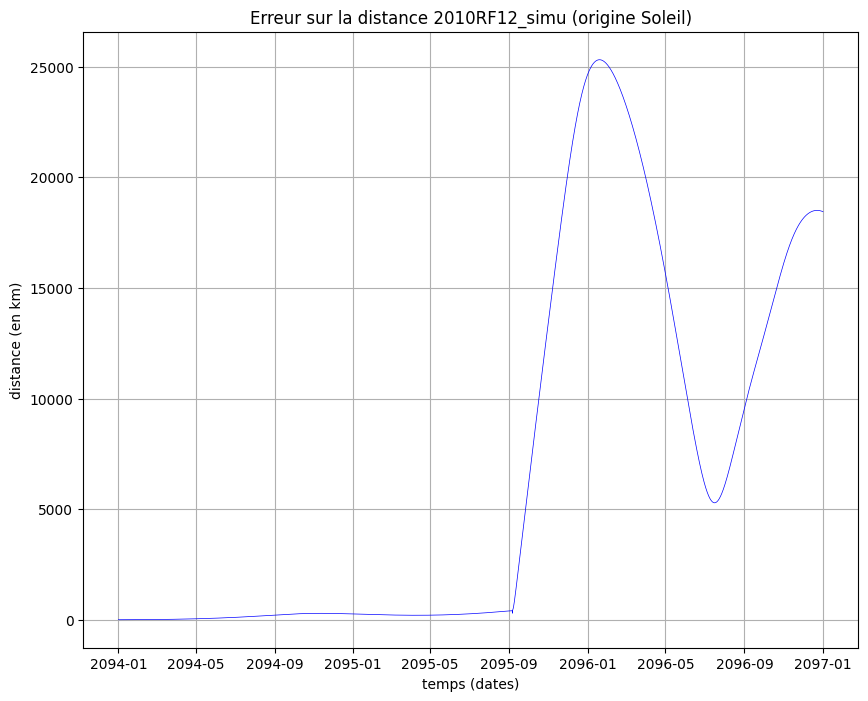

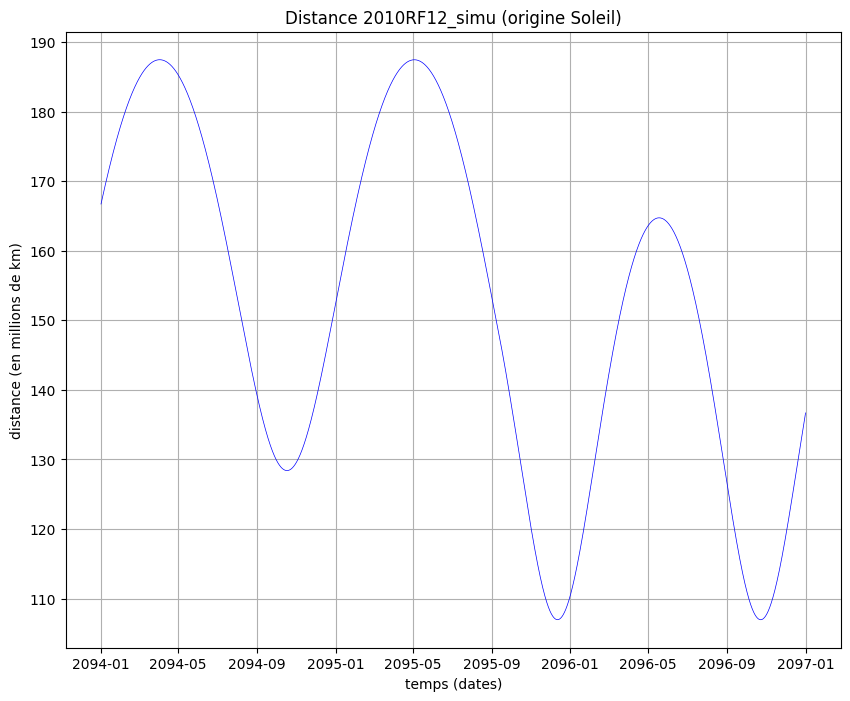

In [ ]:
compare(Astre1_a='Soleil',Astre2_a='2010RF12',Astre1_b='Soleil',Astre2_b='2010RF12_simu')

L'erreur entre la trajectoire JPL et la simulation augmente notablement à partir du passage à proximité de la Terre. On est alors extrêmement sensible aux incertitudes sur le modèle. Le modèle employé ici pour la simulation est trop approximatif par rapport à celui développé par le JPL.

### Trajectoire du 05/09/2095 au 07/09/2095

In [ ]:
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2095-09-05 00:00:00',fin='2095-09-07 00:00:00',pas='1 minutes')

Données pour Soleil
Données pour Mercure
Données pour Venus
Données pour Terre
Données pour Lune
Données pour Mars
Données pour Jupiter
Données pour Saturne
Données pour Uranus
Données pour Neptune
Données pour 2010RF12


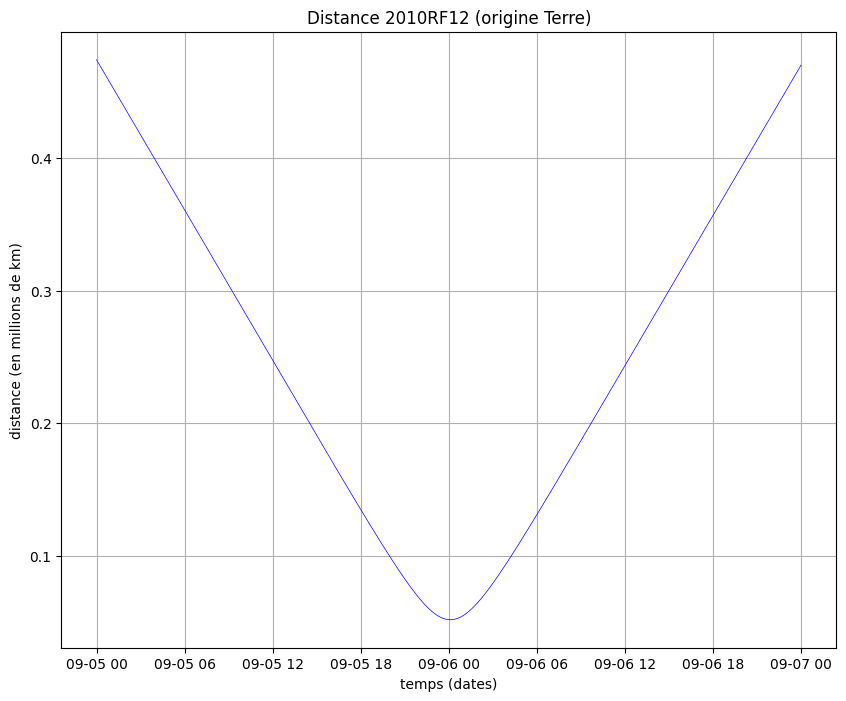

In [ ]:
trace2D(Astre1='Terre', Astre2='2010RF12')

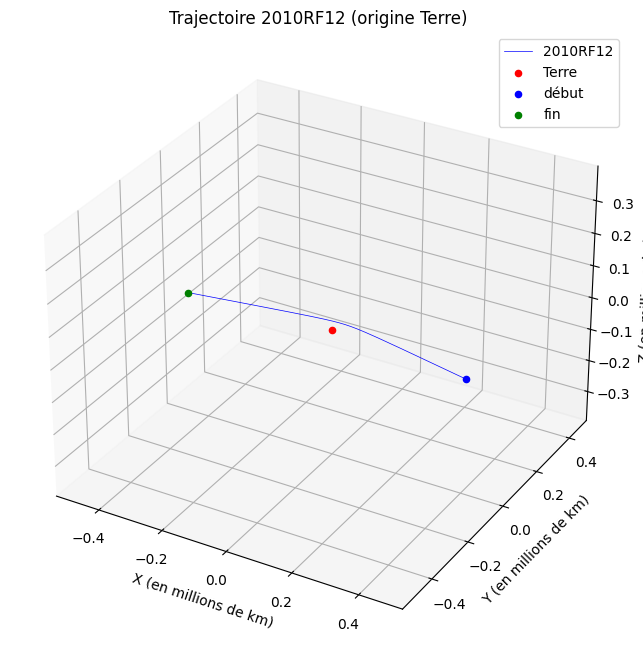

In [ ]:
trace3D(Astre1='Terre', Astre2='2010RF12')

En zoomant, on observe le changement notable de direction au moment du passage près de la Terre.